# Hackingforfuture Task 4 - Predictive Quality Data Analysis

some details on this hackathon... To be filled during the presentation phase.

# Import Libs

In [1]:
import numpy as np
import pandas as pd
import feature_engine as fe

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from feature_engine.categorical_encoders import OneHotCategoricalEncoder

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(48)

# Loading file
The file in our case is transformed into csv-file.

In [2]:
filename = 'csvdata.csv'
df = pd.read_csv(filename)
df.head()

,Time,Date,asm_Force #D,asm_Length #E,asm_Height #F,asm_Press-fit #G,asm_force #H,asm_Length #I,asm_Depth #J,asm_depth #K,...,"fin_Tracking, Zone3 #BU","fin_Tracking, Zone4 #BV","fin_Tracking, Zone1, G #BW","fin_Tracking, Zone2, G #BX","fin_Tracking, Zone3, G #BY","fin_Tracking, Zone4, G #BZ",fin_Shape #CA,fin_pressure #CB,fin_flow #CC,fin_temperature #CD
0,02:02:09,03.01.18,0.149,102.52,0.215,12.747,1.094,135.43,1.8541,1.8517,...,96000.0,139700.0,0.14,0.12,0.07,0.08,V-shape,2.915,0.828,88.15
1,02:02:41,03.01.18,0.163,102.61,0.191,12.731,1.116,135.48,1.8583,1.8556,...,97800.0,138100.0,0.16,0.14,0.06,0.12,V-shape,2.933,1.068,89.14
2,02:05:06,03.01.18,0.160,102.56,0.192,12.734,1.033,135.48,1.8533,1.8487,...,112100.0,140000.0,0.04,0.03,0.02,0.15,V-shape,2.916,0.828,87.30
3,02:05:31,03.01.18,0.158,102.47,0.195,12.726,1.079,135.48,1.8578,1.8546,...,96000.0,140000.0,0.25,0.20,0.07,0.18,Ascending,2.925,1.068,88.68
4,02:08:00,03.01.18,0.154,102.61,0.207,12.752,1.061,135.48,1.8594,1.8543,...,100500.0,137700.0,0.14,0.13,0.10,0.23,Ascending,2.904,0.816,87.29


## Distinguish columns
Due to my laziness to join data table, I created one universal dataframe with prepended column names: `asm_`, `int_`, and `fin_` which stand for assembly data, initial inspection data, and final inspection data respectively.

In [3]:
cols = df.columns.tolist()
# remove # from column names
for idc, c in enumerate(cols):
    for idx, char in enumerate(c):
        if char == '#':
            break
    cols[idc] = c[:idx-1]
cols

['Ti',
 'Da',
 'asm_Force',
 'asm_Length',
 'asm_Height',
 'asm_Press-fit',
 'asm_force',
 'asm_Length',
 'asm_Depth',
 'asm_depth',
 'asm_Depth',
 'asm_parallelism',
 'asm_force',
 'asm_Length',
 'asm_force',
 'asm_Length',
 'asm_torque 1',
 'asm_angle 1',
 'asm_torque 2',
 'asm_angle 2',
 'asm_torque 3',
 'asm_angle 3',
 'asm_torque 1',
 'asm_torque 2',
 'asm_torque 3',
 'asm_angle 1',
 'asm_angle 2',
 'asm_angle 3',
 'asm_torque 1',
 'asm_torque 2',
 'asm_torque 3',
 'asm_torque 4',
 'asm_angle 1',
 'asm_angle 2',
 'asm_angle 3',
 'asm_angle 4',
 'asm_temperature',
 'asm_force',
 'asm_Length',
 'asm_force',
 'asm_Temperature',
 'asm_angle',
 'asm_torque',
 'asm_angle',
 'asm_torque',
 'asm_clearance',
 'int_weight',
 'int_Angle position ',
 'int_weight',
 'int_Angle position',
 'int_Tracking, Zone1',
 'int_Tracking, Zone2',
 'int_Tracking, Zone3',
 'int_Tracking, Zone4',
 'int_Tracking, Zone1, G',
 'int_Tracking, Zone2, G',
 'int_Tracking, Zone3, G',
 'int_Tracking, Zone4, G',
 'int

In [4]:
def redefine_cols(cols):
    cols_asm = [c for c in cols if 'asm_' == c[:4]]
    cols_int = [c for c in cols if 'int_' == c[:4]]
    cols_fin = [c for c in cols if 'fin_' == c[:4]]
    return cols_asm, cols_int, cols_fin
cols_asm, cols_int, cols_fin = redefine_cols(cols)
print("Assembly data columns: {}".format(len(cols_asm)))
print("Initial inspection data columns: {}".format(len(cols_int)))
print("Final inspection data columns: {}".format(len(cols_fin)))

Assembly data columns: 44
Initial inspection data columns: 16
Final inspection data columns: 16


In [5]:
df.columns = cols

# Exploratory Data Analysis
This part involves EDA process. The first step is to find Nan.

In [6]:
# Find Nan
df.isnull().mean()

Ti                        0.000000
Da                        0.000000
asm_Force                 0.000000
asm_Length                0.000000
asm_Height                0.000000
                            ...   
fin_Tracking, Zone4, G    0.042976
fin_Shape                 0.042976
fin_pressure              0.042976
fin_flow                  0.042976
fin_temperature           0.042976
Length: 78, dtype: float64

There are around 5% of Nan in this data set. From the readme file, this is due to quality stuffs or whatever. The Nan are only in the final inspection.

In [7]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16963 entries, 0 to 16962
Data columns (total 78 columns):
Ti                        16963 non-null object
Da                        16963 non-null object
asm_Force                 16963 non-null float64
asm_Length                16963 non-null float64
asm_Height                16963 non-null float64
asm_Press-fit             16963 non-null float64
asm_force                 16963 non-null float64
asm_Length                16963 non-null float64
asm_Depth                 16963 non-null float64
asm_depth                 16963 non-null float64
asm_Depth                 16963 non-null float64
asm_parallelism           16963 non-null float64
asm_force                 16963 non-null float64
asm_Length                16963 non-null float64
asm_force                 16963 non-null float64
asm_Length                16963 non-null float64
asm_torque 1              16963 non-null float64
asm_angle 1               16963 non-null float64
asm_torque 

Most of the data are number variables. There are `Da`, `Ti`, `int_Shape`, and `fin_Shape` which are categorical variables. These variables shall be encoded afterwards.

In [8]:
# After this point will be data processing. The initial dataframe shall be backed up first.
df_bkup = df

# Nan processing
This section dedicates for Nan processing. The quick-dirty process is to remove the Nan out. If there is time left, data imputation can be done.

In [9]:
# remove nan
df = df.dropna()
df.isnull().mean()

Ti                        0.0
Da                        0.0
asm_Force                 0.0
asm_Length                0.0
asm_Height                0.0
                         ... 
fin_Tracking, Zone4, G    0.0
fin_Shape                 0.0
fin_pressure              0.0
fin_flow                  0.0
fin_temperature           0.0
Length: 78, dtype: float64

# Train-test split
Do `train_test_split` here to avoid information leakage. But first of all the label columns should be identified.

In [10]:
# This train_test_split is done under an assumption that the sequence does not matter.
# There will be another analysis that consider the sequence of data.


# X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Da', 'Ti']+label_cols), 
#                                                     df[label_cols], 
#                                                     test_size=0.3, shuffle=False)

# This split considers sequence. 
df.drop(columns=['Da','Ti'], inplace=True)
nrows = df.shape[0]
test_size = int(0.3*nrows)

train = df.head(nrows-test_size)
test = df.tail(test_size)

df.shape, train.shape, test.shape

/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((16234, 76), (11364, 76), (4870, 76))

# Create pipeline

# Transform categorical data to numerical

In [11]:
# distinguish between categorical and numerical var
catcols = ['int_Shape', 'fin_Shape']
numcols = [c for c in cols[2:] if c not in catcols]
numcols

['asm_Force',
 'asm_Length',
 'asm_Height',
 'asm_Press-fit',
 'asm_force',
 'asm_Length',
 'asm_Depth',
 'asm_depth',
 'asm_Depth',
 'asm_parallelism',
 'asm_force',
 'asm_Length',
 'asm_force',
 'asm_Length',
 'asm_torque 1',
 'asm_angle 1',
 'asm_torque 2',
 'asm_angle 2',
 'asm_torque 3',
 'asm_angle 3',
 'asm_torque 1',
 'asm_torque 2',
 'asm_torque 3',
 'asm_angle 1',
 'asm_angle 2',
 'asm_angle 3',
 'asm_torque 1',
 'asm_torque 2',
 'asm_torque 3',
 'asm_torque 4',
 'asm_angle 1',
 'asm_angle 2',
 'asm_angle 3',
 'asm_angle 4',
 'asm_temperature',
 'asm_force',
 'asm_Length',
 'asm_force',
 'asm_Temperature',
 'asm_angle',
 'asm_torque',
 'asm_angle',
 'asm_torque',
 'asm_clearance',
 'int_weight',
 'int_Angle position ',
 'int_weight',
 'int_Angle position',
 'int_Tracking, Zone1',
 'int_Tracking, Zone2',
 'int_Tracking, Zone3',
 'int_Tracking, Zone4',
 'int_Tracking, Zone1, G',
 'int_Tracking, Zone2, G',
 'int_Tracking, Zone3, G',
 'int_Tracking, Zone4, G',
 'int_pressure',
 '

In [12]:
train[catcols[0]].unique(), train[catcols[0]].unique()

(array(['Ascending', 'V-shape', 'Descending', 'Flat'], dtype=object),
 array(['Ascending', 'V-shape', 'Descending', 'Flat'], dtype=object))

In [13]:
train[catcols[1]].unique(), train[catcols[1]].unique()

(array(['V-shape', 'Ascending', 'Descending', 'Flat'], dtype=object),
 array(['V-shape', 'Ascending', 'Descending', 'Flat'], dtype=object))

The two categorical variables have identical categories. This means that there is no missing category in both sets.

In [14]:

ohe_enc = OneHotCategoricalEncoder(
    top_categories=None,
    variables = catcols,
    drop_last=False)
ohe_enc.fit(train)
train = ohe_enc.transform(train)
test = ohe_enc.transform(test)
train.head()

,asm_Force,asm_Length,asm_Height,asm_Press-fit,asm_force,asm_Length,asm_Depth,asm_depth,asm_Depth,asm_parallelism,...,fin_flow,fin_temperature,int_Shape_Ascending,int_Shape_V-shape,int_Shape_Descending,int_Shape_Flat,fin_Shape_V-shape,fin_Shape_Ascending,fin_Shape_Descending,fin_Shape_Flat
0,0.149,102.52,0.215,12.747,1.094,135.43,1.8541,1.8517,1.8535,0.0024,...,0.828,88.15,1,0,0,0,1,0,0,0
1,0.163,102.61,0.191,12.731,1.116,135.48,1.8583,1.8556,1.8602,0.0046,...,1.068,89.14,0,1,0,0,1,0,0,0
2,0.160,102.56,0.192,12.734,1.033,135.48,1.8533,1.8487,1.8526,0.0046,...,0.828,87.30,0,1,0,0,1,0,0,0
3,0.158,102.47,0.195,12.726,1.079,135.48,1.8578,1.8546,1.8583,0.0037,...,1.068,88.68,0,1,0,0,0,1,0,0
4,0.154,102.61,0.207,12.752,1.061,135.48,1.8594,1.8543,1.8616,0.0073,...,0.816,87.29,0,0,1,0,0,1,0,0


In [15]:
# After modifying the columns, redefine the column names
cols_asm, cols_int, cols_fin = redefine_cols(train.columns)
print("Number of initial inspection columns atfter OneHotEncoding: ", len(cols_int))
print("Number of final inspection columns atfter OneHotEncoding: ", len(cols_fin))

Number of initial inspection columns atfter OneHotEncoding:  19
Number of final inspection columns atfter OneHotEncoding:  19


# Scale the numerical data

In [16]:
# let's first have a look on statistical information
np.round(train[cols_int+cols_fin].describe(), 1)

,int_weight,int_weight,int_Angle position,int_weight,int_weight,int_Angle position,"int_Tracking, Zone1","int_Tracking, Zone2","int_Tracking, Zone3","int_Tracking, Zone4",...,"fin_Tracking, Zone2, G","fin_Tracking, Zone3, G","fin_Tracking, Zone4, G",fin_pressure,fin_flow,fin_temperature,fin_Shape_V-shape,fin_Shape_Ascending,fin_Shape_Descending,fin_Shape_Flat
count,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0,...,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0,11364.0
mean,7.5,26.4,181.0,7.5,26.4,189.5,56942.9,72063.9,113281.7,134252.3,...,0.2,0.2,0.2,2.9,1.0,88.4,0.4,0.5,0.1,0.0
std,3.9,13.9,102.4,3.9,13.9,115.9,3759.1,12081.7,9832.7,7074.8,...,0.1,0.1,0.1,0.0,0.1,0.9,0.5,0.5,0.3,0.2
min,0.0,0.3,0.0,0.0,0.3,-109.5,40000.0,65000.0,96000.0,120000.0,...,0.0,0.0,0.0,2.8,0.1,82.3,0.0,0.0,0.0,0.0
25%,4.6,16.0,91.1,4.6,16.0,97.4,54700.0,65000.0,109400.0,129800.0,...,0.1,0.1,0.1,2.9,1.0,87.8,0.0,0.0,0.0,0.0
50%,7.1,24.3,180.4,7.1,24.3,190.8,55400.0,65700.0,119700.0,138000.0,...,0.1,0.2,0.2,2.9,1.0,88.4,0.0,0.0,0.0,0.0
75%,9.9,34.7,270.8,9.9,34.7,282.4,56800.0,68200.0,120000.0,140000.0,...,0.2,0.2,0.3,2.9,1.0,89.0,1.0,1.0,0.0,0.0
max,24.6,89.5,360.0,24.6,89.5,459.8,65000.0,96000.0,120000.0,140000.0,...,1.4,1.4,1.6,3.1,1.1,93.3,1.0,1.0,1.0,1.0


In [79]:
# Create a scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled_val = scaler.transform(train)
test_scaled_val = scaler.transform(test)
train_scaled = pd.DataFrame(train_scaled_val, index=train.index, columns=train.columns)
test_scaled = pd.DataFrame(test_scaled_val, index=test.index, columns=test.columns)
train_scaled.head()

/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,asm_Force,asm_Length,asm_Height,asm_Press-fit,asm_force,asm_Length,asm_Depth,asm_depth,asm_Depth,asm_parallelism,...,fin_flow,fin_temperature,int_Shape_Ascending,int_Shape_V-shape,int_Shape_Descending,int_Shape_Flat,fin_Shape_V-shape,fin_Shape_Ascending,fin_Shape_Descending,fin_Shape_Flat
0,0.347826,0.997179,0.523248,0.807539,0.555048,0.994274,0.595506,0.560773,0.991176,0.110599,...,0.698795,0.529626,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.469565,0.998055,0.519205,0.806525,0.566210,0.994641,0.713483,0.668508,0.994759,0.211982,...,0.939759,0.619872,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.443478,0.997568,0.519373,0.806715,0.524099,0.994641,0.573034,0.477901,0.990695,0.211982,...,0.698795,0.452142,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.426087,0.996693,0.519879,0.806208,0.547438,0.994641,0.699438,0.640884,0.993743,0.170507,...,0.939759,0.577940,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.391304,0.998055,0.521900,0.807856,0.538305,0.994641,0.744382,0.632597,0.995508,0.336406,...,0.686747,0.451231,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Identify target label's tolerance from training set

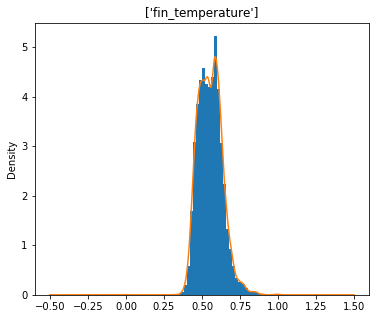

In [90]:
label_cols = ['fin_temperature']
ok_std = 2

fig=plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
train_scaled[label_cols].plot.hist(bins=50, ax=ax, normed=True)
train_scaled[label_cols].plot.density(ax=ax)
plt.title(label_cols)
ax.get_legend().remove()

In [106]:
label_mean = train_scaled[label_cols].mean().values[0]
label_std = train_scaled[label_cols].std().values[0]
label_std

0.07861215782918889

In [117]:
train_scaled['label'] = (np.abs(train_scaled[label_cols] - label_mean) < ok_std*label_std)*1
test_scaled['label'] = (np.abs(test_scaled[label_cols] - label_mean) < ok_std*label_std)*1
train_scaled.head()

,asm_Force,asm_Length,asm_Height,asm_Press-fit,asm_force,asm_Length,asm_Depth,asm_depth,asm_Depth,asm_parallelism,...,int_Shape_Ascending,int_Shape_V-shape,int_Shape_Descending,int_Shape_Flat,fin_Shape_V-shape,fin_Shape_Ascending,fin_Shape_Descending,fin_Shape_Flat,label,mean_diff
0,0.347826,0.997179,0.523248,0.807539,0.555048,0.994274,0.595506,0.560773,0.991176,0.110599,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1
1,0.469565,0.998055,0.519205,0.806525,0.566210,0.994641,0.713483,0.668508,0.994759,0.211982,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1
2,0.443478,0.997568,0.519373,0.806715,0.524099,0.994641,0.573034,0.477901,0.990695,0.211982,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1
3,0.426087,0.996693,0.519879,0.806208,0.547438,0.994641,0.699438,0.640884,0.993743,0.170507,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1
4,0.391304,0.998055,0.521900,0.807856,0.538305,0.994641,0.744382,0.632597,0.995508,0.336406,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,1


Text(0, 0.5, 'Number of observations per bin')

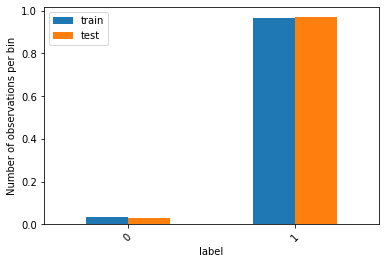

In [119]:
t1 = train_scaled.groupby(['label'])['label'].count() / len(train_scaled)
t2 = test_scaled.groupby(['label'])['label'].count() / len(test_scaled)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

In [130]:
X_train = train_scaled.drop(columns=label_cols+['label'])
X_test = test_scaled.drop(columns=label_cols+['label'])
y_train = train_scaled['label']
y_test = test_scaled['label']
X_test.shape, X_train.shape

((4870, 81), (11364, 81))

# Model

In [131]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

clf = svm.SVC(gamma='scale')
param_grid = {
    'kernel': ('linear', 'rbf'),
    'C': [1:10]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [157]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
best = grid_search.best_estimator_
y_pred = best.predict(X_test)
cm = confusion_matrix(y_test, pred)

In [177]:
cm.shape

(2, 2)

Confusion matrix, without normalization
[[   0  146]
 [   0 4724]]


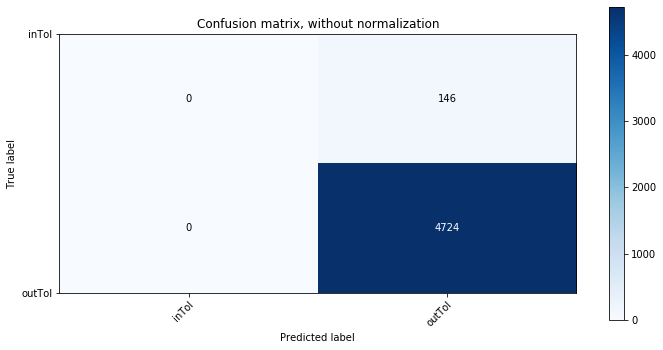

In [180]:

from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, 0.5*i+0.25, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(y_test, y_pred, classes=['inTol', 'outTol'],
                      title='Confusion matrix, without normalization')
plt.show()